# Overview


We are going to recognize hand gestures from a video sequence. To recognize these gestures from a live video sequence, we need to do three things...
1.  We, first need to segment the hand region alone removing all the unwanted portions in the video sequence. 
2.  After segmenting the hand region, we then pass that region to the trained 2D CNN model, to predict the hand gesture.

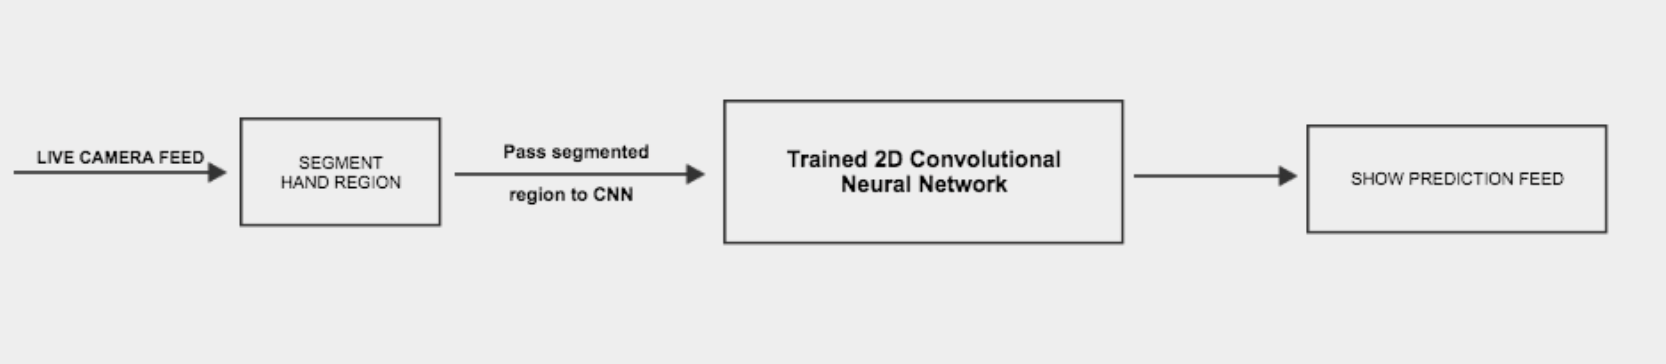

# Segment the Hand region

The first step in hand gesture recognition is obviously to find the hand region by eliminating all the other unwanted portions in the video sequence. 

In order to get the segment, we do three things 

- Background Subtraction
- Motion Detection and Thresholding
- Contour Extraction


### Background Subtraction

Background subtraction (BS) is a common and widely used technique for generating a foreground mask 
(namely, a binary image containing the pixels belonging to moving objects in the scene) by using static cameras.
It calculates the foreground mask performing a subtraction between the current frame and a background model, 
containing the static part of the scene or, more in general, everything that can be considered as background 
given the characteristics of the observed scene.


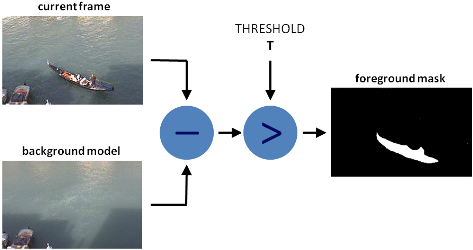


After figuring out the background model using running averages, we use the current frame which holds the foreground object (hand in our case) in addition to the background. We calculate the absolute difference between the background model (updated over time) and the current frame (which has our hand) to obtain a difference image that holds the newly added foreground object (which is our hand). This is what Background Subtraction is all about.

### Motion Detection and Thresholding

To detect the hand region from this difference image, we need to threshold the difference image, so that only our hand region 
becomes visible and all the other unwanted regions are painted as black. This is what Motion Detection is all about.


Thresholding is the assigment of pixel intensities to 0's and 1's based a particular threshold level so that our 
object of interest alone is captured from an image.



### Contour Extraction

After thresholding the difference image, we find contours in the resulting image. The contour with the largest area is assumed to be our hand.

#### Note: Contour is the outline or boundary of an object located in an image.



In [ ]:
import cv2
import numpy as np
import os

import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
% matplotlib inline
import glob

In [ ]:
# # Starts capturing video
# cap = cv2.VideoCapture(0)

# fps = int(cap.get(cv2.CAP_PROP_FPS))

# print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

# while cap.isOpened():
#     ret, frame = cap.read()
#     cv2.imshow('Captured Frame', frame)
#     if cv2.waitKey(1) == ord('q'):
#         break

#     keypress = cv2.waitKey(1) & 0xFF

# cap.release()
# cv2.destroyAllWindows()


In [ ]:
#---------------------------------------------
# To segment the region of hand in the image
#---------------------------------------------
def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

# PART 2 - Train and predict hand gesture with 2D CNN Model

### Now, Having segmented the hand region from the live video sequence, we do the following:
1. Create a 2D Convolutional Neural Network Model using keras
2. Train the CNN model using the different gestures dataset
3. Get the thresholded image from live feed and use model to predict the hand gesture in image

### 2D CNN Model

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam


# model
model = Sequential()

# first conv layer
# input shape = (img_rows, img_cols, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,120, 1))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(6, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

### Training the model with the dataset

In [ ]:
# Loading the Dataset

DATASET_PATH = '/kaggle/input/hand-gesture-recog-dataset/data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

In [ ]:
import cv2
image = cv2.imread('/kaggle/input/hand-gesture-recog-dataset/data/five/hand1(1015).jpg')
image = cv2.resize(image,(100, 120))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
loaded_images = []

list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

for path in range(0, len(dataset_path)):
    dataset_path = "/kaggle/input/hand-gesture-recog-dataset/data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

outputVectors = []
for i in range(1, 1601):
    outputVectors.append([1, 0, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 1, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 1, 0, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 1, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 1, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 0, 1])

print(len(outputVectors))

In [ ]:
X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(X.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 100, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 120, 1)
print(X_train.shape)
print(X_test.shape)

In [ ]:
# Training the model with data
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

# model.save("hand_gesture_recognition.h5")

In [ ]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))

### Get the thresholded image from live feed and use model to predict the hand gesture in image

## Run LIVE FEED

In [ ]:
# load Model Weights

def _load_weights():
    try:
        model = load_model("hand_gesture_recog_model.h5")
        print(model.summary())
        # print(model.get_weights())
        # print(model.optimizer)
        return model
    except Exception as e:
        return None


    
def getPredictedClass(model):

    image = cv2.imread('Temp.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (100, 120))

    gray_image = gray_image.reshape(1, 100, 120, 1)

    prediction = model.predict_on_batch(gray_image)

    predicted_class = np.argmax(prediction)
    if predicted_class == 0:
        return "Blank"
    elif predicted_class == 1:
        return "OK"
    elif predicted_class == 2:
        return "Thumbs Up"
    elif predicted_class == 3:
        return "Thumbs Down"
    elif predicted_class == 4:
        return "Punch"
    elif predicted_class == 5:
        return "High Five"


if __name__ == "__main__":
    # initialize accumulated weight
    accumWeight = 0.5

    # get the reference to the webcam
    camera = cv2.VideoCapture(0)

    fps = int(camera.get(cv2.CAP_PROP_FPS))
    # region of interest (ROI) coordinates
    top, right, bottom, left = 10, 350, 225, 590
    # initialize num of frames
    num_frames = 0
    # calibration indicator
    calibrated = False
    model = _load_weights()
    k = 0
    # keep looping, until interrupted
    while (True):
        # get the current frame
        (grabbed, frame) = camera.read()

        # resize the frame
        frame = cv2.resize(frame, (700,700))
        # flip the frame so that it is not the mirror view
        frame = cv2.flip(frame, 1)

        # clone the frame
        clone = frame.copy()

        # get the height and width of the frame
        (height, width) = frame.shape[:2]

        # get the ROI
        roi = frame[top:bottom, right:left]

        # convert the roi to grayscale and blur it
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # to get the background, keep looking till a threshold is reached
        # so that our weighted average model gets calibrated
        if num_frames < 30:
            run_avg(gray, accumWeight)
            if num_frames == 1:
                print("[STATUS] please wait! calibrating...")
            elif num_frames == 29:
                print("[STATUS] calibration successfull...")
        else:
            # segment the hand region
            hand = segment(gray)

            # check whether hand region is segmented
            if hand is not None:
                # if yes, unpack the thresholded image and
                # segmented region
                (thresholded, segmented) = hand

                # draw the segmented region and display the frame
                cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))

                # count the number of fingers
                # fingers = count(thresholded, segmented)
                if k % (fps / 6) == 0:
                    cv2.imwrite('Temp.png', thresholded)
                    predictedClass = getPredictedClass(model)
                    cv2.putText(clone, str(predictedClass), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # show the thresholded image
                cv2.imshow("Thesholded", thresholded)
        k = k + 1
        # draw the segmented hand
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

        # increment the number of frames
        num_frames += 1

        # display the frame with segmented hand
        cv2.imshow("Video Feed", clone)

        # observe the keypress by the user
        keypress = cv2.waitKey(1) & 0xFF

        # if the user pressed "q", then stop looping
        if keypress == ord("q"):
            break

    # free up memory
    camera.release()
    cv2.destroyAllWindows()


# WebCam Live feed to predict Hand Gestures

In [ ]:
from IPython.display import Video

Video('input/hand-gesture-video/compress_Hand_Gesture_2.mp4', embed=True)